# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. 

Author - Tejas Kapasi

About the Project: 

#### Total 5 output classes
1. Thumbs up:  Increase the volume
2. Thumbs down: Decrease the volume
3. Left swipe: 'Jump' backwards 10 seconds
4. Right swipe: 'Jump' forward 10 seconds  
5. Stop: Pause the movie
- Each video is a sequence of 30 frames (or images)
- We should build model which should be light enough to fit into memory of webcam!

#### Two architecture to be followed:
1. One is the standard CNN + RNN architecture in which you pass the images of a video through a CNN which extracts a feature vector for each image, and then pass the sequence of these feature vectors through an RNN.
2. CNNs - a 3D convolutional network

In [1]:
!pip install imageio
!pip install scikit-image
!pip install opencv-python
!pip install tensorflow

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import os
import imageio.v2 as imageio
from imageio.v2 import imread
from skimage.transform import resize
import datetime
import cv2
from PIL import Image
import matplotlib.pyplot as plt 

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 64 #128,150 - Didn't work -  #experiment with the batch size

In [5]:
# Specifying Constants 

num_classes = 5  # total no of classes
ht = 84         # height of image (desired)
wd = 84         # width of image (desired)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
"""
1. Randomizing folder order each time it's called.
2. Resizing and normalizing images to ensure they match required input dimensions.
3. Handling both full and partial batches to ensure no data is left unused.
"""
    
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)

    # Define a list of image indices to be used from each video
    # By using this index, the function only selects every 3rd frame out of the first 30 frames, resulting in 10 frames for each video sample.
    img_idx = np.arange(0,30,2) #e.g [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28] - Step Size used is 2. 

    # Infinite loop to keep yielding batches of data for training
    while True:

        # Shuffle folder list to randomize the order for each epoch
        t = np.random.permutation(folder_list)
        
        # calculate the number of batches
        num_batches = len(folder_list)//batch_size 
        
        # Loop through each batch
        for batch in range(num_batches):

            # Initialize arrays for the batch data and labels
            # shape (batch_size, x, y, z, channels)
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            # Each element in batch_data represents one video sample
            batch_data = np.zeros((batch_size,len(img_idx),ht,wd,3)) 
            
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5)) 
            
            # Loop over each folder in the current batch
            for folder in range(batch_size): 

                # Fetch the list of image files in the folder
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 

                # Loop through specified frames to load images
                for idx,item in enumerate(img_idx): 

                    # Load and preprocess the image
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    # This line crops the image to focus on a central region and then resizes it to a smaller, 
                    # consistent size, which helps to reduce computational load while preserving essential features in the cropped central area.
                    if image.shape[1] == 160:

                        #  This crops the image horizontally, removing parts of the left and right sides, keeping only the middle portion.
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)

                    # Resize the image to a consistent size for Conv3D input
                    # image = resize(image,(120,120))

                    # Normalize the image based on percentile values for better contrast
                    image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)

                    # Assign the normalized image channels to the batch data array
                    batch_data[folder,idx,:,:,0] = image[:,:,0]#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]#normalise and feed in the image
                
                # Assign a one-hot encoded label based on class information in folder name    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            # Yield the batch data and labels to the model
            yield batch_data, batch_labels 

        # Handle any remaining images if the number of folders is not a perfect multiple of batch size
        rem_image = len(folder_list)%batch_size
        batch += 1
        if(rem_image!=0):

            # Initialize arrays for remaining data and labels
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((rem_image,len(img_idx),ht,wd,3)) 

            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((rem_image,5)) 

            # Process the remaining folders in the batch
            for folder in range(rem_image): 
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)

                    
                    # image = resize(image,(120,120))
                    image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            # Yield the remaining batch data and labels
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers

#### Model_1 - No Dropouts , No Batch Normalization and RELU activation function - Very Basic Model.

In [9]:
input_shape= (len(np.arange(0,30,2)),ht,wd,3)    #(30,120,120,3)
print(input_shape)

num_epochs = 15
print ('# epochs =', num_epochs)

(15, 84, 84, 3)
# epochs = 15


In [10]:
conv3d_model1 = Sequential()

conv3d_model1.add(Conv3D(16, kernel_size=(3,3,3), input_shape=input_shape, padding='same', activation = 'relu'))
conv3d_model1.add(MaxPooling3D(pool_size=(2,2,2)))

conv3d_model1.add(Conv3D(32, (3,3,3),padding='same', activation='relu'))
conv3d_model1.add(MaxPooling3D(pool_size=(2,2,2)))

conv3d_model1.add(Conv3D(64, (3,3,3),padding='same', activation='relu'))
conv3d_model1.add(MaxPooling3D(pool_size=(2,2,2)))

conv3d_model1.add(Flatten())

conv3d_model1.add(Dense(128, activation='relu'))
conv3d_model1.add(Dense(5, activation='softmax'))

#Optimisers and Compiling the Model. 
optimiser = optimizers.Adam()
conv3d_model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model1.summary())

# Generator that will be used in fit 
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 84, 84, 16)    1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 42, 42, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 42, 42, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 21, 21, 32)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 3, 21, 21, 64)     55360     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 1, 10, 10, 64)    0

2024-10-29 13:45:56.932615: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-10-29 13:45:56.932684: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

# Callbacks setup
checkpoint = ModelCheckpoint(
    filepath, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=False, 
    mode='min', 
    save_weights_only=False
)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)
callbacks_list = [checkpoint, LR]

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [13]:
history = conv3d_model1.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    initial_epoch=0
)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/15


2024-10-29 13:46:08.404043: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 43.3309 - categorical_accuracy: 0.2368Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2024-10-2913_45_56.214700/model-00001-43.33093-0.23680-1.64878-0.23000.keras
11/11 [==============================] - 118s 11s/step - loss: 43.3309 - categorical_accuracy: 0.2368 - val_loss: 1.6488 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.5796 - categorical_accuracy: 0.2640
Epoch 00002: saving model to model_init_2024-10-2913_45_56.214700/model-00002-1.57965-0.26395-1.56750-0.32000.keras
11/11 [==============================] - 106s 11s/step - loss: 1.5796 - categorical_accuracy: 0.2640 - val_loss: 1.5675 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 1.4193 - categorical_accuracy: 0.4223
Epoch 00003: saving model to model_init_2024-10-2913_45_5

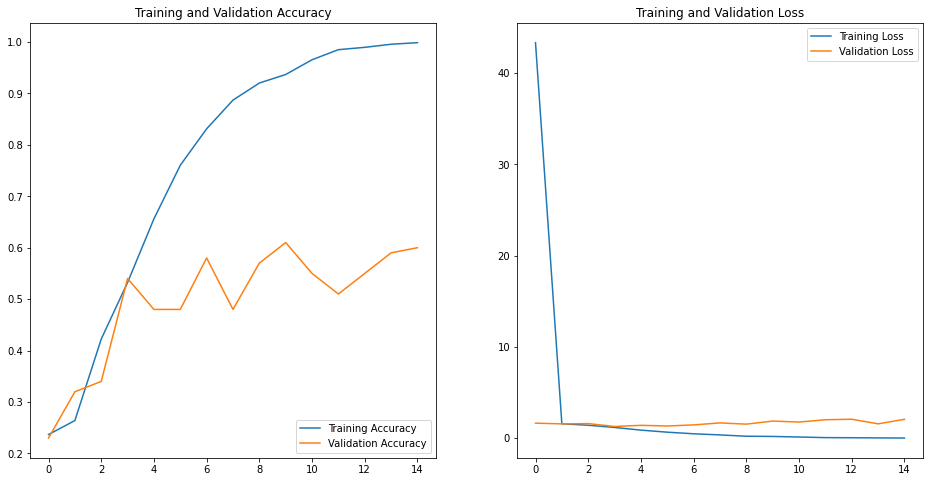

In [14]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model1 - Inferences: 

- Looks Overfitting, As Training Accuracy is really good but Validation Accuracy is poor. 

In [15]:
# conv3d_model1.save('model-1.keras')

### Model_2 - Now Adding `BatchNormalization` and `Dropouts` and Increasing `Batch Size`

In [16]:
batch_size = 100

In [17]:
conv3d_model2 = Sequential()

conv3d_model2.add(Conv3D(16, kernel_size=(3,3,3), input_shape=input_shape, padding='same', activation = 'relu'))
conv3d_model2.add(BatchNormalization())
conv3d_model2.add(MaxPooling3D(pool_size=(2,2,2)))

conv3d_model2.add(Conv3D(32, (3,3,3),padding='same', activation='relu'))
conv3d_model2.add(BatchNormalization())
conv3d_model2.add(MaxPooling3D(pool_size=(2,2,2)))

conv3d_model2.add(Conv3D(64, (3,3,3),padding='same', activation='relu'))
conv3d_model2.add(MaxPooling3D(pool_size=(2,2,2)))

conv3d_model2.add(Flatten())

conv3d_model2.add(Dropout(0.5))

conv3d_model2.add(Dense(128, activation='relu'))
conv3d_model2.add(Dense(5, activation='softmax'))

#Optimisers and Compiling the Model. 
optimiser = optimizers.Adam()
conv3d_model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model2.summary())

# Generator that will be used in fit 
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 84, 84, 16)    1312      
                                                                 
 batch_normalization (BatchN  (None, 15, 84, 84, 16)   64        
 ormalization)                                                   
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 42, 42, 16)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 42, 42, 32)     13856     
                                                                 
 batch_normalization_1 (Batc  (None, 7, 42, 42, 32)    128       
 hNormalization)                                                 
                                                      

In [18]:
history = conv3d_model2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    initial_epoch=0
)

Source path =  /home/datasets/Project_data/train ; batch size = 100
Epoch 1/15
7/7 [==============================] - ETA: 0s - loss: 5.9935 - categorical_accuracy: 0.2097 Source path =  /home/datasets/Project_data/val ; batch size = 100

Epoch 00001: saving model to model_init_2024-10-2913_45_56.214700/model-00001-5.99347-0.20965-1.83974-0.21000.keras
7/7 [==============================] - 88s 14s/step - loss: 5.9935 - categorical_accuracy: 0.2097 - val_loss: 1.8397 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/15
7/7 [==============================] - ETA: 0s - loss: 1.6622 - categorical_accuracy: 0.2323 
Epoch 00002: saving model to model_init_2024-10-2913_45_56.214700/model-00002-1.66222-0.23228-1.59262-0.25000.keras
7/7 [==============================] - 88s 15s/step - loss: 1.6622 - categorical_accuracy: 0.2323 - val_loss: 1.5926 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/15
7/7 [==============================] - ETA: 0s - loss: 1.5821 - categorical_accurac

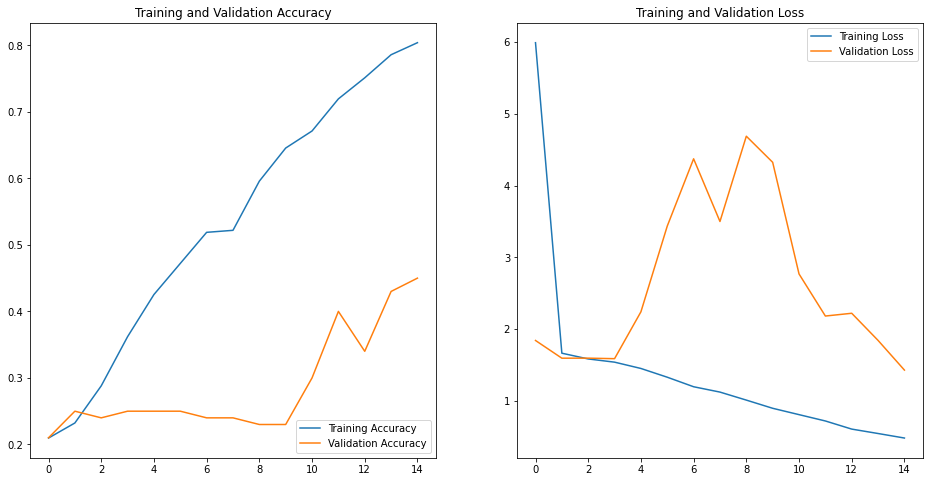

In [19]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model_2 - Inference

- Its clearly evident larget batch size didn't help
- Its visible clearly again Overfitting as it works well will only taining data. 

### Model_3 - Let's try similar as first one but play with Depth of network meaning adjusting neurons in the layer. Also going back to batch size 64. 

In [20]:
batch_size = 64
num_epochs = 20

In [21]:
conv3d_model3 = Sequential()

conv3d_model3.add(Conv3D(16, kernel_size=(3,3,3), input_shape=input_shape, padding='same', activation = 'relu'))
conv3d_model3.add(MaxPooling3D(pool_size=(2,2,2)))

conv3d_model3.add(Conv3D(32, (3,3,3),padding='same', activation='relu'))
conv3d_model3.add(MaxPooling3D(pool_size=(2,2,2)))

conv3d_model3.add(Conv3D(64, (3,3,3),padding='same', activation='relu'))
conv3d_model3.add(MaxPooling3D(pool_size=(2,2,2)))

conv3d_model3.add(Flatten())

# Only making change in this layer. Reducing from 128 to 64. 
conv3d_model3.add(Dense(64, activation='relu'))
conv3d_model3.add(Dense(5, activation='softmax'))

#Optimisers and Compiling the Model. 
optimiser = optimizers.Adam()
conv3d_model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model3.summary())

# Generator that will be used in fit 
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 84, 84, 16)    1312      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 7, 42, 42, 16)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 42, 42, 32)     13856     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 3, 21, 21, 32)    0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 3, 21, 21, 64)     55360     
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 1, 10, 10, 64)   

In [22]:
history = conv3d_model3.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    initial_epoch=0
)

Source path =  /home/datasets/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 19.0601 - categorical_accuracy: 0.1991Source path =  /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2024-10-2913_45_56.214700/model-00001-19.06015-0.19910-1.69582-0.26000.keras
11/11 [==============================] - 96s 10s/step - loss: 19.0601 - categorical_accuracy: 0.1991 - val_loss: 1.6958 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.6195 - categorical_accuracy: 0.2112
Epoch 00002: saving model to model_init_2024-10-2913_45_56.214700/model-00002-1.61955-0.21116-1.58107-0.29000.keras
11/11 [==============================] - 83s 8s/step - loss: 1.6195 - categorical_accuracy: 0.2112 - val_loss: 1.5811 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.4795 - categorical

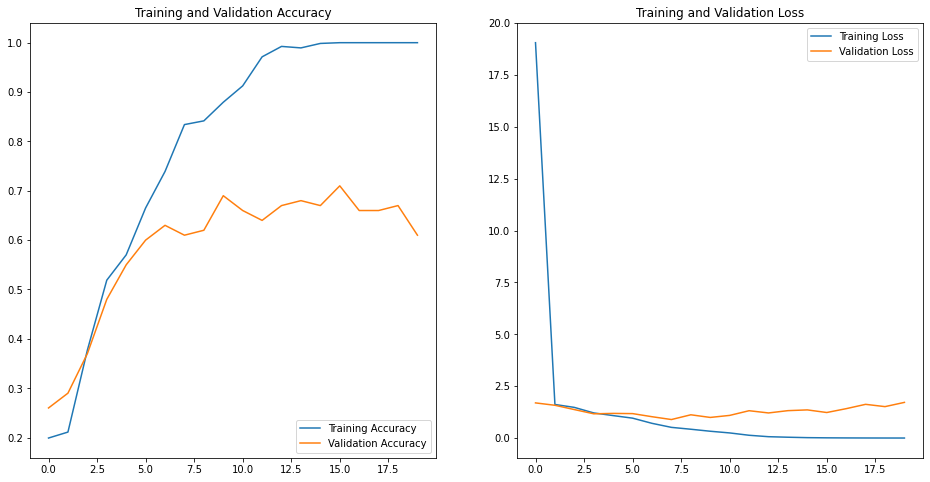

In [23]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model_3 : Inferences 

- with limited parameter its good model.
- Slightly better model for Conv3d.
- Accuracy is improved. 

In [24]:
#### Model 4 - Reducing batch Size further and check once. 

In [25]:
batch_size = 32
num_epochs = 15

In [26]:
conv3d_model4 = Sequential()

conv3d_model4.add(Conv3D(16, kernel_size=(3,3,3), input_shape=input_shape, padding='same', activation = 'relu'))
conv3d_model4.add(MaxPooling3D(pool_size=(2,2,2)))

conv3d_model4.add(Conv3D(32, (3,3,3),padding='same', activation='relu'))
conv3d_model4.add(MaxPooling3D(pool_size=(2,2,2)))

conv3d_model4.add(Conv3D(64, (3,3,3),padding='same', activation='relu'))
conv3d_model4.add(MaxPooling3D(pool_size=(2,2,2)))

conv3d_model4.add(Flatten())

# Only making change in this layer. Reducing from 64 to 32. 
conv3d_model4.add(Dense(64, activation='relu'))
conv3d_model4.add(Dense(5, activation='softmax'))

#Optimisers and Compiling the Model. 
optimiser = optimizers.Adam()
conv3d_model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model4.summary())

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Generator that will be used in fit 
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 15, 84, 84, 16)    1312      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 42, 42, 16)    0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 42, 42, 32)     13856     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 3, 21, 21, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_11 (Conv3D)          (None, 3, 21, 21, 64)     55360     
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 1, 10, 10, 64)   

In [27]:
history = conv3d_model4.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    initial_epoch=0
)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 19.1576 - categorical_accuracy: 0.2157Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2024-10-2913_45_56.214700/model-00001-19.15760-0.21569-1.60944-0.18000.keras
21/21 [==============================] - 86s 4s/step - loss: 19.1576 - categorical_accuracy: 0.2157 - val_loss: 1.6094 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.5858 - categorical_accuracy: 0.2564
Epoch 00002: saving model to model_init_2024-10-2913_45_56.214700/model-00002-1.58581-0.25641-1.63079-0.20000.keras
21/21 [==============================] - 85s 4s/step - loss: 1.5858 - categorical_accuracy: 0.2564 - val_loss: 1.6308 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.4446 - categorical_

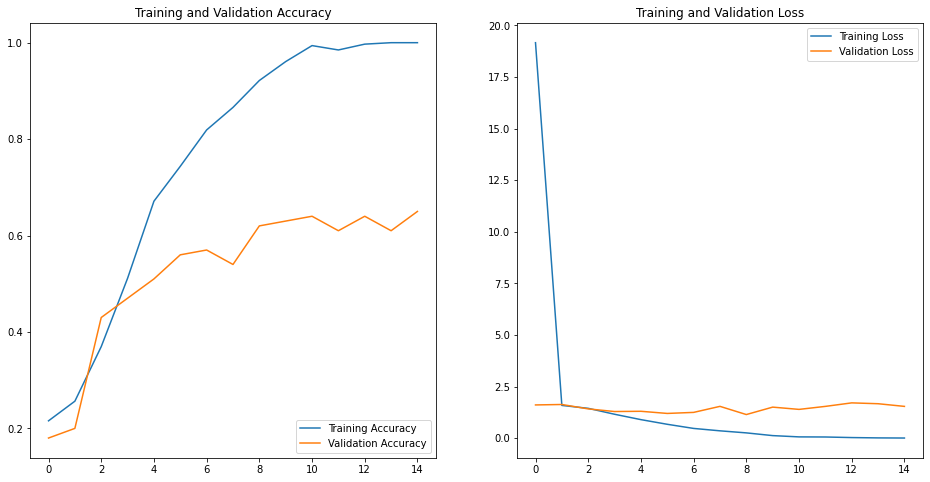

In [28]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model 4 - Inferences

- This is by far best model we can consider with minimal parameters.
- Its giving same as model 1 output but limited learnable parameters. 

#### Model 5 - Let's try one final variation, 

- Add 1 hidden layer , Keeping batch Size 32 and Using Dropouts = 25% 

In [29]:
conv3d_model5 = Sequential()

conv3d_model5.add(Conv3D(16, kernel_size=(3,3,3), input_shape=input_shape, padding='same', activation = 'relu'))
conv3d_model5.add(MaxPooling3D(pool_size=(2,2,2)))

conv3d_model5.add(Conv3D(32, (3,3,3),padding='same', activation='relu'))
conv3d_model5.add(MaxPooling3D(pool_size=(2,2,2)))

conv3d_model5.add(Conv3D(64, (3,3,3),padding='same', activation='relu'))
conv3d_model5.add(MaxPooling3D(pool_size=(2,2,2)))

conv3d_model5.add(Flatten())

conv3d_model5.add(Dropout(0.25))

# Only making change in this layer. Reducing from 64 to 32. 
conv3d_model5.add(Dense(64, activation='relu'))
conv3d_model5.add(Dense(5, activation='softmax'))

#Optimisers and Compiling the Model. 
optimiser = optimizers.Adam()
conv3d_model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv3d_model5.summary())

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Generator that will be used in fit 
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 84, 84, 16)    1312      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 7, 42, 42, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 42, 42, 32)     13856     
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 3, 21, 21, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 3, 21, 21, 64)     55360     
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 1, 10, 10, 64)   

In [30]:
history = conv3d_model5.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    initial_epoch=0
)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 12.8065 - categorical_accuracy: 0.2081Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2024-10-2913_45_56.214700/model-00001-12.80652-0.20814-1.58939-0.23000.keras
21/21 [==============================] - 85s 4s/step - loss: 12.8065 - categorical_accuracy: 0.2081 - val_loss: 1.5894 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.3286 - categorical_accuracy: 0.4434
Epoch 00003: saving model to model_init_2024-10-2913_45_56.214700/model-00003-1.32864-0.44344-1.19769-0.52000.keras
21/21 [==============================] - 84s 4s/step - loss: 1.3286 - categorical_accuracy: 0.4434 - val_loss: 1.1977 - val_categorical_accuracy: 0.5200 - lr: 0.0010
Epoch 4/15
21/21 [==============================] - ETA: 0s - loss: 0.9922 - categorical_

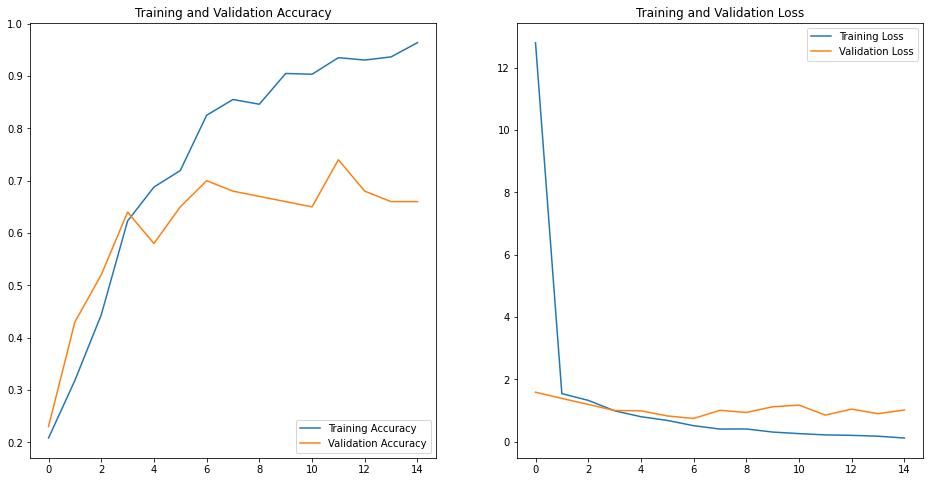

In [31]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model 5 : Inferences

- Not much difference. Moralless same as previous model. 

### Now, Let's try with CNN + RNN architecture. 

- We can use Transfer learning techniques for 2D CNN
- Stacking LSTM or GRU on top of it.
- 

In [32]:
from tensorflow.keras.layers import MaxPooling2D,Dense, GRU, Dropout, Flatten, TimeDistributed, LSTM

#### CNN RNN Model - 1, Using `ResNet50` , `Early Stopping` , `Batch Normalization` , `MaxPooling 2d` , `GRU(64)` , `Dropout(0.25)` and `Dropout(0.5)` 

In [33]:
num_epochs = 30

In [34]:
from tensorflow.keras.applications import ResNet50

#mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
resnet50_transfer = ResNet50(include_top=False, weights='imagenet',input_shape=(ht,wd,3))


94781440/94765736 [==============================] - 6s 0us/step


In [35]:
cnn_rnn_m1 = Sequential()

cnn_rnn_m1.add(TimeDistributed(resnet50_transfer,input_shape=input_shape))

cnn_rnn_m1.add(TimeDistributed(BatchNormalization()))
cnn_rnn_m1.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_rnn_m1.add(TimeDistributed(Flatten()))

cnn_rnn_m1.add(GRU(64))
cnn_rnn_m1.add(Dropout(0.25))

cnn_rnn_m1.add(Dense(64,activation='relu'))
cnn_rnn_m1.add(Dropout(0.5))

cnn_rnn_m1.add(Dense(5, activation='softmax'))

#Optimisers and Compiling the Model. 
optimiser = optimizers.Adam()
cnn_rnn_m1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn_rnn_m1.summary())

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR,earlystop,earlystop]

# Generator that will be used in fit 
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 3, 3, 2048)   23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 3, 3, 2048)   8192      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 1, 1, 2048)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 2048)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 64)               

In [36]:
history = cnn_rnn_m1.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    initial_epoch=0
)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6236 - categorical_accuracy: 0.3077Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2024-10-2913_45_56.214700/model-00001-1.62362-0.30769-1.59600-0.26000.keras


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


21/21 [==============================] - 98s 4s/step - loss: 1.6236 - categorical_accuracy: 0.3077 - val_loss: 1.5960 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.1651 - categorical_accuracy: 0.5430
Epoch 00002: saving model to model_init_2024-10-2913_45_56.214700/model-00002-1.16508-0.54299-1.99609-0.26000.keras
21/21 [==============================] - 85s 4s/step - loss: 1.1651 - categorical_accuracy: 0.5430 - val_loss: 1.9961 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.8716 - categorical_accuracy: 0.6531
Epoch 00003: saving model to model_init_2024-10-2913_45_56.214700/model-00003-0.87159-0.65309-1.63132-0.30000.keras
21/21 [==============================] - 86s 4s/step - loss: 0.8716 - categorical_accuracy: 0.6531 - val_loss: 1.6313 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - ETA: 0

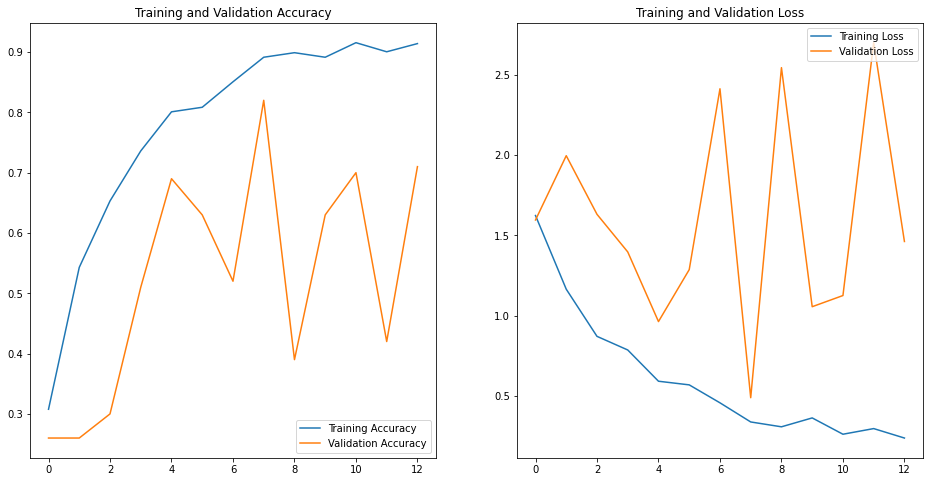

In [38]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(13)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### CNN RNN Model 1 - Inferences

- Using Early Stopping Technique, This model is performing good.
- This doesn't seems over fitting.
- Still let's try different variation.

#### CNN RNN Model 2 - Trying `LSTM` instead of `GRU`, Removing Batch Normalization and Max Pooling. 

In [39]:
from tensorflow.keras.layers import LSTM

In [40]:
num_epochs = 15

In [41]:
cnn_rnn_m2 = Sequential()

cnn_rnn_m2.add(TimeDistributed(resnet50_transfer,input_shape=input_shape))

cnn_rnn_m2.add(TimeDistributed(Flatten()))

cnn_rnn_m2.add(LSTM(128,return_sequences=True))
cnn_rnn_m2.add(LSTM(64))
cnn_rnn_m2.add(Dropout(0.25))

cnn_rnn_m2.add(Dense(64,activation='relu'))
cnn_rnn_m2.add(Dropout(0.5))

cnn_rnn_m2.add(Dense(5, activation='softmax'))

#Optimisers and Compiling the Model. 
optimiser = optimizers.Adam()
cnn_rnn_m2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn_rnn_m2.summary())

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR,earlystop,earlystop]

# Generator that will be used in fit 
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 15, 3, 3, 2048)   23587712  
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 15, 18432)        0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 15, 128)           9503232   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)               

In [42]:
history = cnn_rnn_m2.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    initial_epoch=0
)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 0.8983 - categorical_accuracy: 0.7149Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2024-10-2913_45_56.214700/model-00001-0.89833-0.71493-2.44370-0.22000.keras
21/21 [==============================] - 97s 4s/step - loss: 0.8983 - categorical_accuracy: 0.7149 - val_loss: 2.4437 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.5236 - categorical_accuracy: 0.8582
Epoch 00002: saving model to model_init_2024-10-2913_45_56.214700/model-00002-0.52356-0.85822-2.96675-0.26000.keras
21/21 [==============================] - 86s 4s/step - loss: 0.5236 - categorical_accuracy: 0.8582 - val_loss: 2.9668 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.3946 - categorical_acc

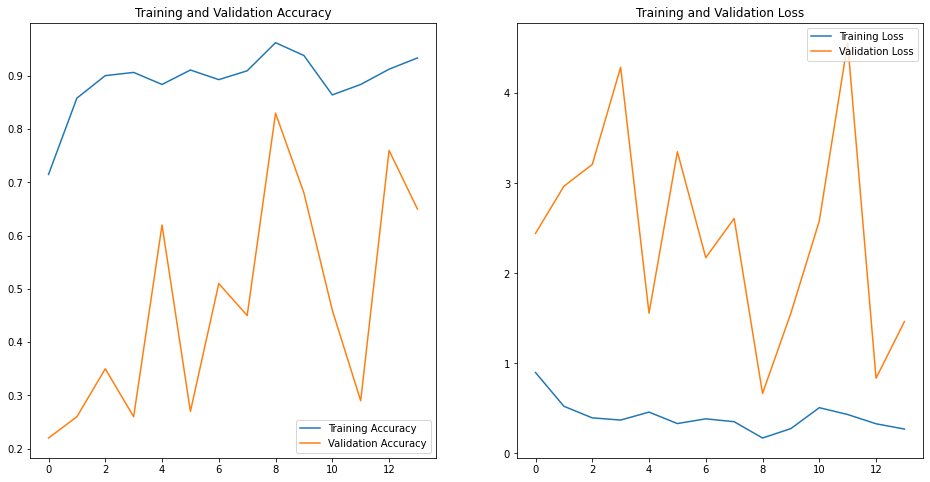

In [43]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(14)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inferences :

- This seems to be good fit with limited parameters. 